In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2

import glob
import matplotlib.pyplot as plt

import tensorflow.keras.layers as tfl
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import  Dense, BatchNormalization, ReLU, Dropout, Conv2D, MaxPooling2D, Flatten, Add, GlobalAveragePooling2D, concatenate#, Average, Concatenate, SpatialDropout2D
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras import Input,models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

import imgaug as ia
import imgaug.augmenters as iaa

from google.colab import drive
from google.colab import files


In [2]:
drive.mount("/content/drive", force_remount=True)
%cd drive/MyDrive/Colab Notebooks/

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [3]:
label_encoder = {"Basketball" : 0, "Football" : 1, "Rowing" : 2, "Swimming" : 3, "Tennis" : 4, "Yoga" : 5}

In [4]:
augmentation = iaa.Sequential([
    # 1. Flip
    iaa.Fliplr(0.5),
    # 2. Affine
    iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
               rotate=(-10, 10),
               scale=(0.9, 1.2),
                shear=(-2, 2),),
               
    # 3. Multiply
    iaa.Multiply((0.8, 1.2)),
    # 4. Linearcontrast
    iaa.LinearContrast((0.8, 1.2)),
    # Perform methods below only sometimes
    iaa.Sometimes(0.7,
        # 5. GaussianBlur
        iaa.GaussianBlur((0.2, 0.5))
        )
])


In [5]:
imgsP1 = glob.glob(f"./NN_DataSet/Train/*")
TrainImgs = []
TrainLabel = []
# x = 325 , y = 420
for f in imgsP1: 
  img = cv2.imread(f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img.astype(np.float32)
  img = cv2.resize(img, (192,192), interpolation = cv2.INTER_AREA)
  
  TrainImgs.append(img/255)
  l =  label_encoder[f.split('/')[3].split('_')[0]]
  TrainLabel.append(l)
  n = 5 if l == 0 else 3
  for i in range(n):
    augmented_img = augmentation(image=img)
    TrainImgs.append(augmented_img/255)
    TrainLabel.append(l)


TrainImgs = np.array(TrainImgs)
TrainLabel = np.reshape(TrainLabel,(-1,1))
del imgsP1

In [6]:
X_train, X_test, y_train, y_test = train_test_split(TrainImgs, TrainLabel, test_size=0.2, random_state=32)

In [7]:
X_train.shape, X_test.shape

((5692, 192, 192, 3), (1424, 192, 192, 3))

In [8]:
del TrainImgs
del TrainLabel

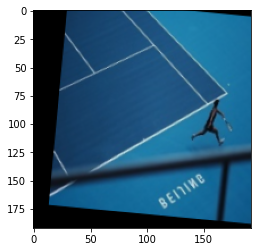

In [9]:
plt.imshow(X_train[2,:])

In [10]:
model = Sequential([
  Input(shape=(192,192,3)),    
  BatchNormalization(),
  Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"),
  Conv2D(filters=32,kernel_size=3,padding="same", activation="relu"),
  MaxPooling2D(pool_size=2,strides=2),
  Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
  Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
  MaxPooling2D(pool_size=2,strides=2),
  Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
  Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
  Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
  MaxPooling2D(pool_size=2,strides=2),
  Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
  Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
  Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
  MaxPooling2D(pool_size=2,strides=2),
  Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
  Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"),
  Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"),
  MaxPooling2D(pool_size=2,strides=2),
  Flatten(),
  Dense(units=128,activation="relu",kernel_regularizer=L1L2(0.001,0.01)),
  Dropout(0.6),
  Dense(units=64,activation="relu",kernel_regularizer=L1L2(0.001,0.01)),
  Dropout(0.4),
  Dense(units=6, activation="softmax"),
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 192, 192, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 32)        9

In [12]:
model.compile(optimizer=Adam(learning_rate=0.0005,)
,loss=SparseCategoricalCrossentropy()
           ,metrics=["accuracy"] )#,metrics=["accuracy"]

In [13]:
model.fit(X_train, y_train, batch_size=64, epochs=50)

Epoch 1/50
89/89 [==============================] - 24s 199ms/step - loss: 6.8032 - accuracy: 0.3396
Epoch 2/50
89/89 [==============================] - 16s 175ms/step - loss: 2.4153 - accuracy: 0.3958
Epoch 3/50
89/89 [==============================] - 16s 178ms/step - loss: 1.9648 - accuracy: 0.4361
Epoch 4/50
89/89 [==============================] - 16s 177ms/step - loss: 1.6877 - accuracy: 0.5251
Epoch 5/50
89/89 [==============================] - 15s 174ms/step - loss: 1.4720 - accuracy: 0.5717
Epoch 6/50
89/89 [==============================] - 15s 174ms/step - loss: 1.3893 - accuracy: 0.6017
Epoch 7/50
89/89 [==============================] - 15s 174ms/step - loss: 1.3009 - accuracy: 0.6254
Epoch 8/50
89/89 [==============================] - 16s 176ms/step - loss: 1.2482 - accuracy: 0.6398
Epoch 9/50
89/89 [==============================] - 16s 175ms/step - loss: 1.1982 - accuracy: 0.6643
Epoch 10/50
89/89 [==============================] - 15s 174ms/step - loss: 1.1372 - accura

KeyboardInterrupt: ignored

In [14]:
Ptest = model.predict(X_train)
s1 = np.sum(np.argmax(Ptest, axis=1) == y_train[:,0])/Ptest.shape[0]
del Ptest
del X_train
del y_train
s1

178/178 [==============================] - 6s 30ms/step


0.9198875614898102

In [15]:
Ptest = model.predict(X_test)
s2 = np.sum(np.argmax(Ptest, axis=1) == y_test[:,0])/Ptest.shape[0]
del Ptest
del X_test
del y_test
s2

45/45 [==============================] - 2s 35ms/step


0.8560393258426966

In [16]:
imgsP2 = glob.glob(f"./NN_DataSet/Test/*")
TestImgs = []
testID = []
# x = 500 , y = 700
for f in imgsP2:
  img = cv2.imread(f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img.astype(np.float32)
  img = cv2.resize(img, (192,192), interpolation = cv2.INTER_AREA)


  img /= 255
  TestImgs.append(img)
  testID.append(f.split('/')[3])

TestImgs = np.array(TestImgs)
del imgsP2

In [17]:
tests = model.predict(TestImgs)
tests = np.argmax(tests, axis=1)
col1 = pd.DataFrame(testID,columns=["image_name"]).reset_index(drop=True)
col2 = pd.DataFrame(tests,columns=["label"]).reset_index(drop=True)
sub = pd.concat([col1,col2],axis=1)#.reset_index(drop=True)
sub.to_csv("./submissionVGG1.csv",index=False)

22/22 [==============================] - 2s 31ms/step
